In [1]:
%matplotlib widget

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

from astropy.io import fits
from astropy.table import Table

from lvmdrp.core import rss
from lvmdrp.functions import rssMethod

In [2]:
# TODO:
# read fiberflat table
# match fiberflat table with analyzed flats
# map wavelength solution from arcs

In [3]:
CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}
CHANNEL_ARC = {"b1": "sdR-s-b1-00002382", "r1": "sdR-s-r1-00002461", "z1": "sdR-s-z1-00002460"}

fiberflat_path = "_data-lvm/fiberflats-spec1"
fiberflat_list = [path.replace(".ms.fits", "") for path in os.listdir(fiberflat_path) if path.endswith(".ms.fits")]

for label in fiberflat_list:
    ccd = label.split("-")[2]
    arc_name = CHANNEL_ARC[ccd]

    rssMethod.createPixTable_drp(
        rss_in=f"{fiberflat_path}/{label}.ms.fits",
        rss_out=f"{fiberflat_path}/{label}.rss.fits",
        arc_wave=f"_data-lvm/{arc_name}.disp.fits",
        arc_fwhm=f"_data-lvm/{arc_name}.res.fits",
        cropping=''
    )
    try:
        rssMethod.resampleWave_drp(
            rss_in=f"{fiberflat_path}/{label}.rss.fits",
            rss_out=f"{fiberflat_path}/{label}.disp_cor.fits",
            start_wave=CHANNEL_WL[ccd][0], end_wave=CHANNEL_WL[ccd][1], disp_pix="1.0", err_sim="0", method="linear", parallel=0
        )
    except IndexError:
        continue

sdR-s-b1-00002176
sdR-s-z1-00002189
sdR-s-r1-00002175


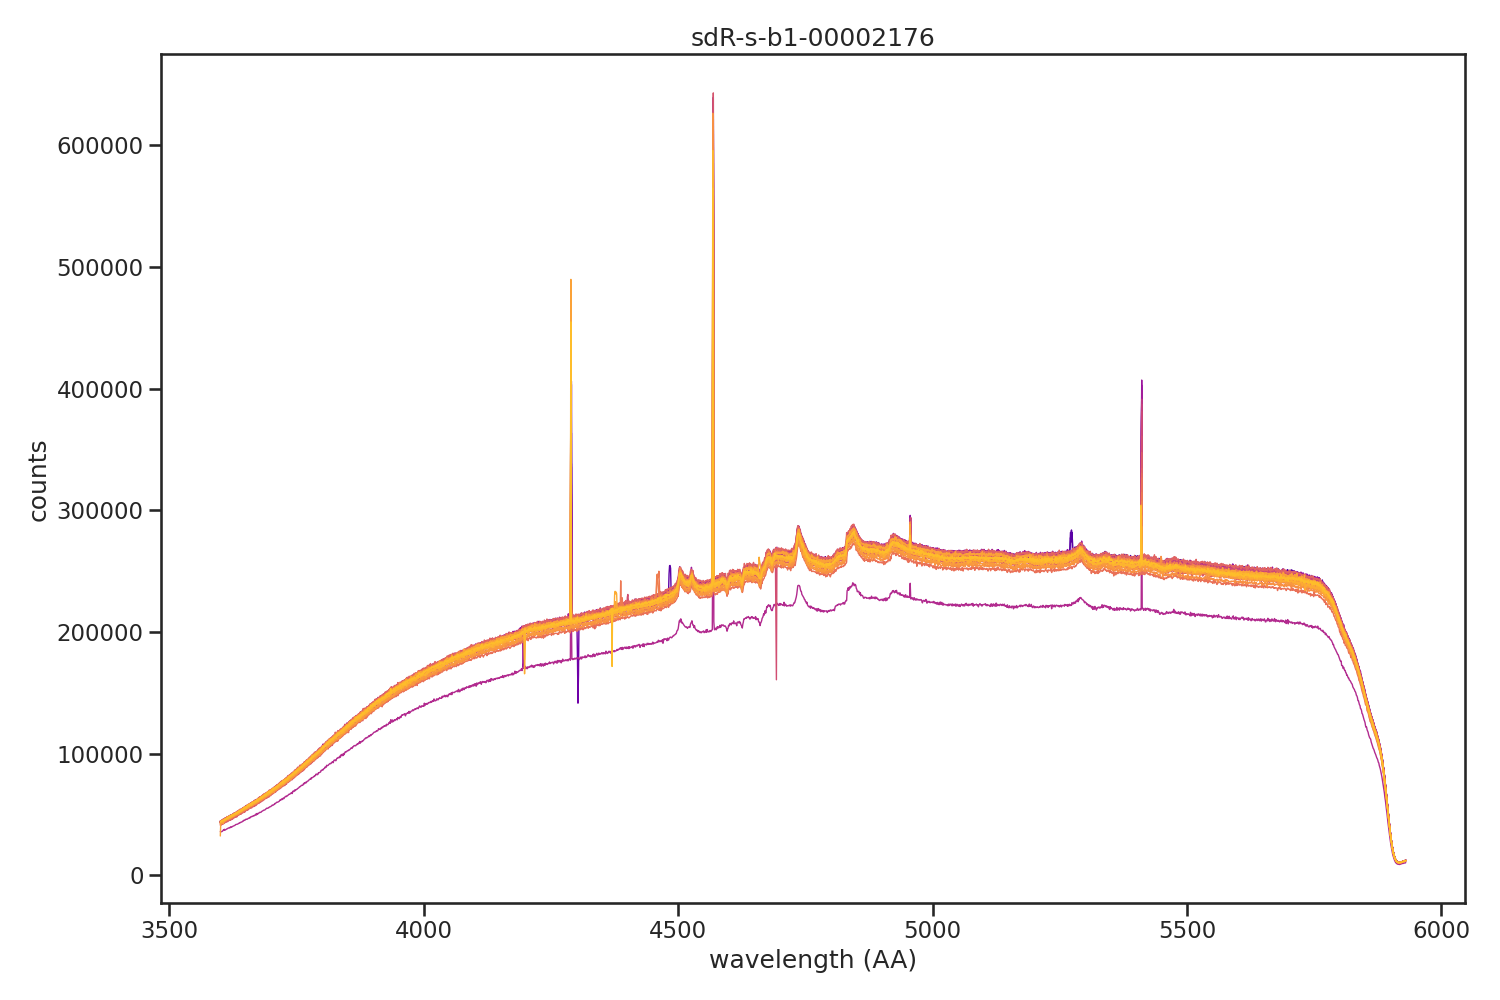

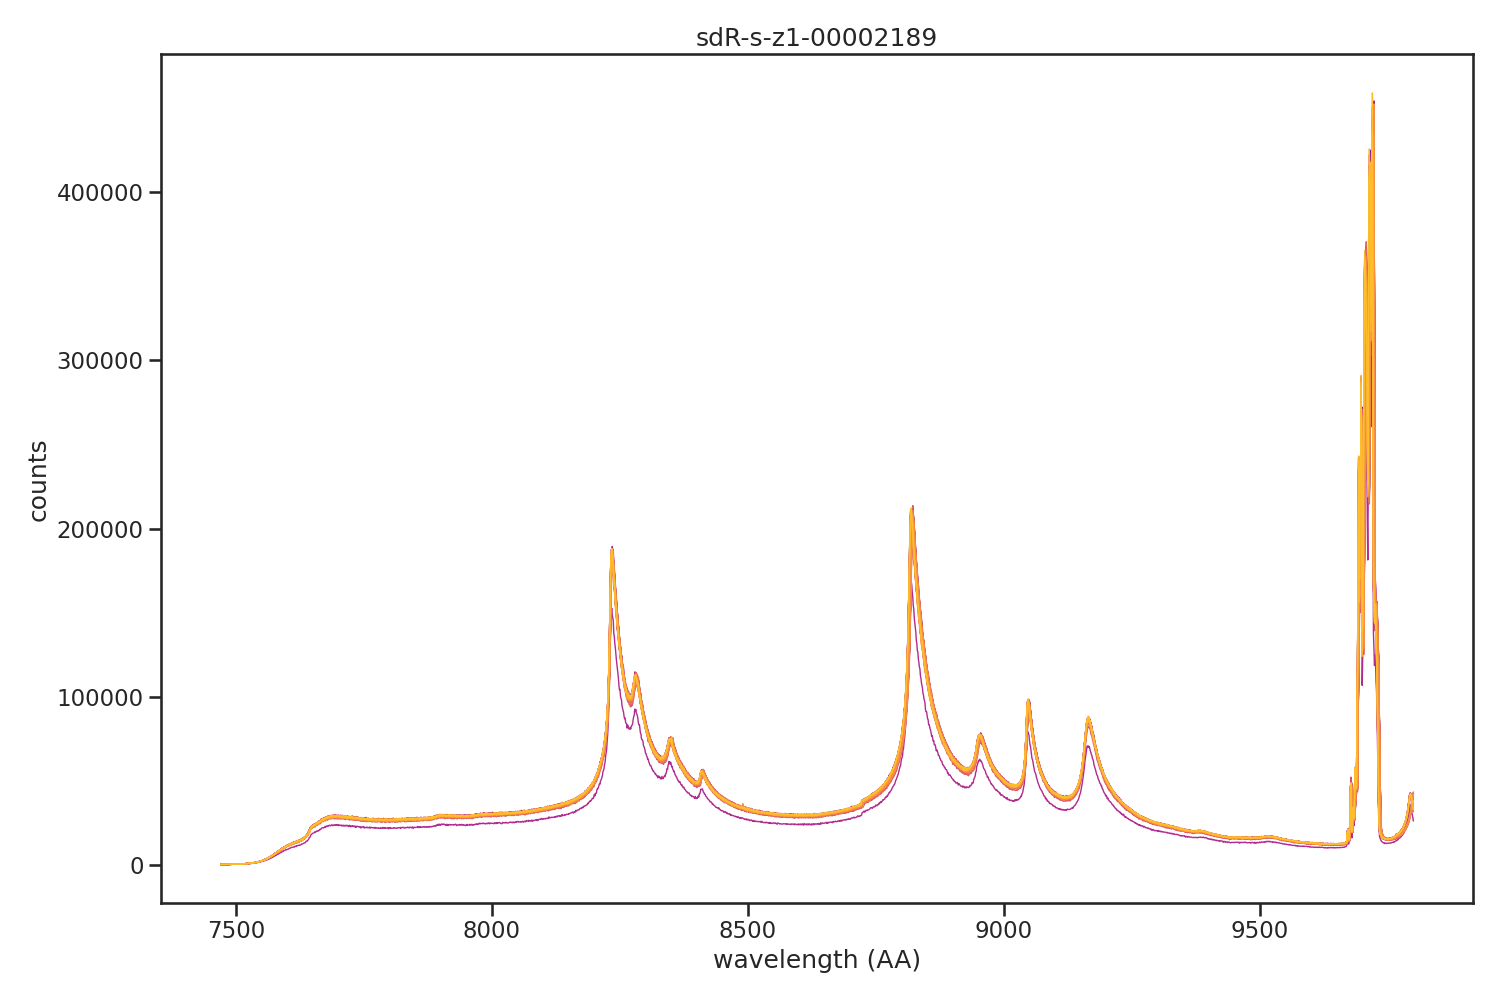

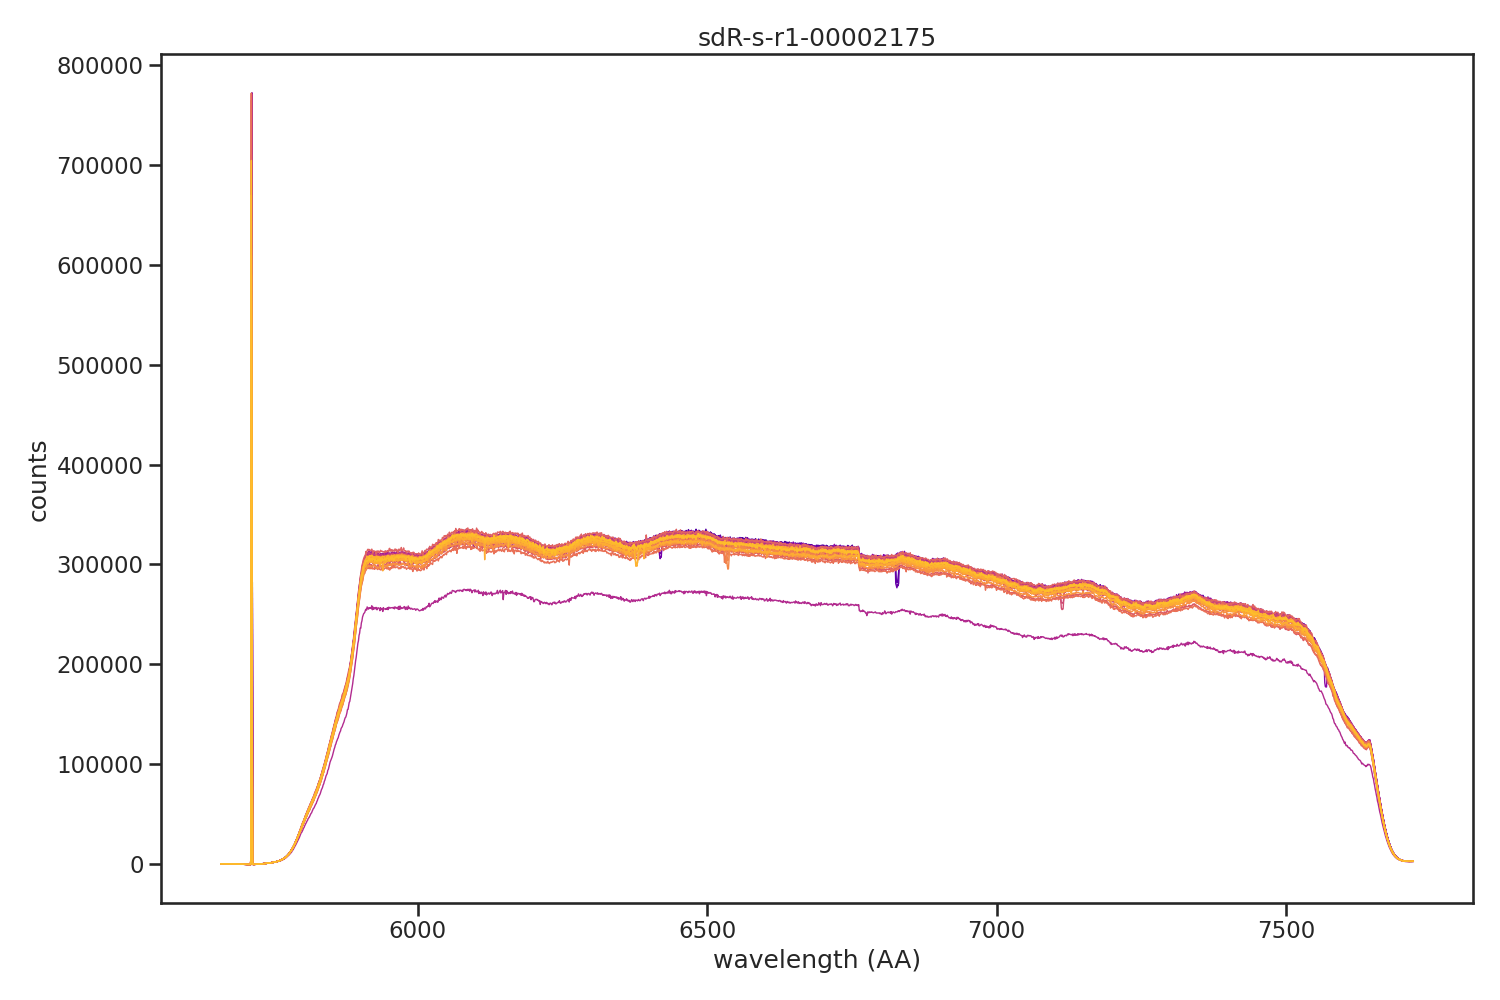

In [4]:
iflats = [0, 1, 11]
itrim = 5
jtrim = 10

for iflat in iflats:
    label = fiberflat_list[iflat]
    print(label)
    ccd = label.split("-")[2]
    fiberflat = rss.loadRSS(f"{fiberflat_path}/{label}.disp_cor.fits")
    # fiberflat_med = np.mean(fiberflat._data[itrim:-itrim], axis=0)
    # fiberflat._data = fiberflat._data / fiberflat_med
    # fiberflat = fiberflat.createFiberFlat(smooth_poly=2)

    fig, ax = plt.subplots(figsize=(15,10))
    # ax.set_yscale("log")
    colors = sns.color_palette("plasma", fiberflat._fibers)
    for ifiber in range(itrim,fiberflat._fibers-itrim):
        fiber = fiberflat.getSpec(ifiber)
        ax.plot(fiber._wave[~fiber._mask], fiber._data[~fiber._mask], color=colors[ifiber], lw=1)
    ax.set_xlabel("wavelength (AA)")
    ax.set_ylabel("counts")
    ax.set_title(label)
    fig.tight_layout()
    # fig.savefig(f"continuum-{ccd}.png", bbox_inches="tight")

In [5]:
fiberflat_b = rss.loadRSS(f"{fiberflat_path}/{fiberflat_list[0]}.rss.fits")
fiberflat_r = rss.loadRSS(f"{fiberflat_path}/{fiberflat_list[11]}.rss.fits")
fiberflat_z = rss.loadRSS(f"{fiberflat_path}/{fiberflat_list[1]}.rss.fits")

# fiberflat_b._error = 1 / fiberflat_b._error
# fiberflat_r._error = 1 / fiberflat_r._error
# fiberflat_z._error = 1 / fiberflat_z._error

delta_wave = 0.5

spectra_br = []
for ifiber in range(41):
    spec_b = fiberflat_b.getSpec(ifiber)
    spec_r = fiberflat_r.getSpec(ifiber)
    spec_br = spec_b.coaddSpec(spec_r, wave=np.arange(spec_b._wave[0], spec_r._wave[-1]+delta_wave, delta_wave))
    
    spectra_br.append(spec_br)

spectra = []
for ifiber in range(41):
    spec_br = spectra_br[ifiber]
    spec_z = fiberflat_z.getSpec(ifiber)
    spec_brz = spec_br.coaddSpec(spec_z, wave=np.arange(spec_br._wave[0], spec_z._wave[-1]+delta_wave, delta_wave))

    spec_brz = spec_brz.resampleSpec(np.arange(3600, 9800+delta_wave, delta_wave), method="linear")
    
    spectra.append(spec_brz)

fiberflat_brz = rss.RSS.from_spectra1d(spectra)

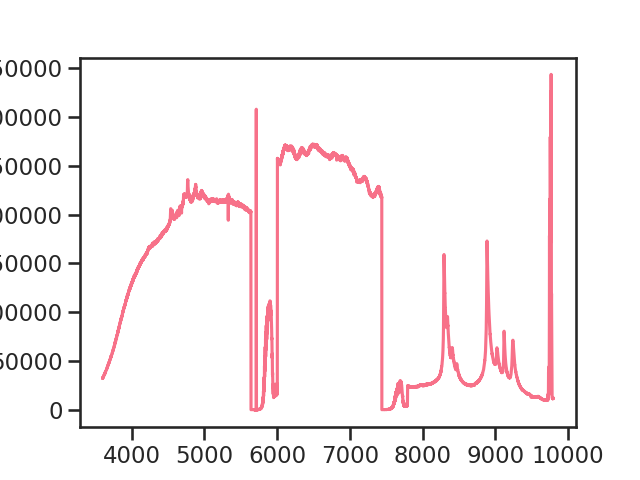

In [14]:
plt.figure()
plt.plot(fiberflat_brz[0]._wave, fiberflat_brz[0]._data)